## inference cell embedding & save

In [2]:
import scanpy as sc

# Load the preprocessed AnnData
input_path = '../data/sample/raw_h5ad/Kanemaru2023_downsampled_10000_cells.h5ad'
adata = sc.read_h5ad(input_path)

In [ ]:
from epiagent.preprocessing import global_TFIDF
from epiagent.tokenization import tokenization
import numpy as np
import os

cCRE_document_frequency = np.load('../data/cCRE_document_frequency.npy')

# Apply TF-IDF
print("Applying TF-IDF...")
global_TFIDF(adata, cCRE_document_frequency)

# Tokenize the data
print("Tokenizing the data...")
tokenization(adata)

# Save the processed AnnData
processed_output_dir = "../data/sample/processed_h5ad/"
os.makedirs(processed_output_dir, exist_ok=True)
processed_output_path = os.path.join(processed_output_dir, "Kanemaru2023_downsampled_10000_cells_cellsentenced.h5ad")
adata.write(processed_output_path)
print(f"Processed data saved at {processed_output_path}")

Applying TF-IDF...


Tokenizing the data...
Tokenization complete: 'cell_sentences' column added to adata.obs.
Processed data saved at ../data/sample/processed_h5ad/Kanemaru2023_downsampled_10000_cells_cellsentenced.h5ad


- start from here

In [1]:
import scanpy as sc

# Load the preprocessed AnnData
input_path = '../data/sample/processed_h5ad/Kanemaru2023_downsampled_10000_cells_cellsentenced.h5ad'
adata = sc.read_h5ad(input_path)

In [2]:
from epiagent.dataset import CellDataset, collate_fn
from torch.utils.data import DataLoader

# Extract cell sentences from the AnnData object
cell_sentences = adata.obs['cell_sentences'].tolist()

# Create the inference dataset
inference_cell_dataset = CellDataset(
    cell_sentences=cell_sentences,
    max_length=8192,
    is_random=False
)

# Create the inference DataLoader
inference_batch_size = 8
inference_dataloader = DataLoader(
    inference_cell_dataset,
    batch_size=inference_batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)


- model_path 변경

In [3]:
from epiagent.model import EpiAgent
import torch
import torch.nn as nn

# Specify the path to the pre-trained model
# model_path = '../model/pretrained_EpiAgent.pth'
model_path = '../model/finetune_DI_epoch100/checkpoint_DI_epoch_50.pth'

# Set the device (GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the EpiAgent model with appropriate configurations
loaded_model = EpiAgent(
    vocab_size=1355449,
    num_layers=18,
    embedding_dim=512,
    num_attention_heads=8,
    max_rank_embeddings=8192,
    use_flash_attn=True,
    pos_weight_for_RLM=torch.tensor(1.),
    pos_weight_for_CCA=torch.tensor(1.)
)

# Set criterion for signal reconstruction (SR)
loaded_model.criterion_SR = nn.MSELoss()

# Load the pre-trained weights into the model
loaded_model.load_state_dict(torch.load(model_path))


# Ensure the CCA loss uses a positive weight of 1
loaded_model.criterion_CCA.pos_weight = torch.tensor(1.)

# Move the model to the specified device
loaded_model.to(device)

/workspace/epiagent/venv311/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/workspace/epiagent/venv311/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/workspace/epiagent/venv311/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/workspace/epiagent/venv311/lib/python3.11/site-packages/flash_attn/ops/triton/layer_norm.py:984: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fw

EpiAgent(
  (cCRE_embedding): Embedding(1355449, 512)
  (rank_embedding): Embedding(8192, 512)
  (EpiAgent_transformer): BertEncoder(
    (layers): ModuleList(
      (0-17): 18 x Block(
        (mixer): MHA(
          (Wqkv): LinearResidual(in_features=512, out_features=1536, bias=True)
          (inner_attn): FlashSelfAttention(
            (drop): Dropout(p=0.1, inplace=False)
          )
          (inner_cross_attn): FlashCrossAttention(
            (drop): Dropout(p=0.1, inplace=False)
          )
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (drop_path1): StochasticDepth(p=0.0, mode=row)
        (norm1): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (dropout2): Dropout(p=0.1, inplace=False)
        (d

In [4]:
from epiagent.inference import infer_cell_embeddings

# Extract cell embeddings using the fine-tuned model
cell_embeddings = infer_cell_embeddings(loaded_model, device, inference_dataloader)

# Assign the embeddings to the AnnData object
adata.obsm['cell_embeddings'] = cell_embeddings

/workspace/epiagent/venv311/lib/python3.11/site-packages/epiagent/inference.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision for faster inference


## visualize umap

- title, save 변경

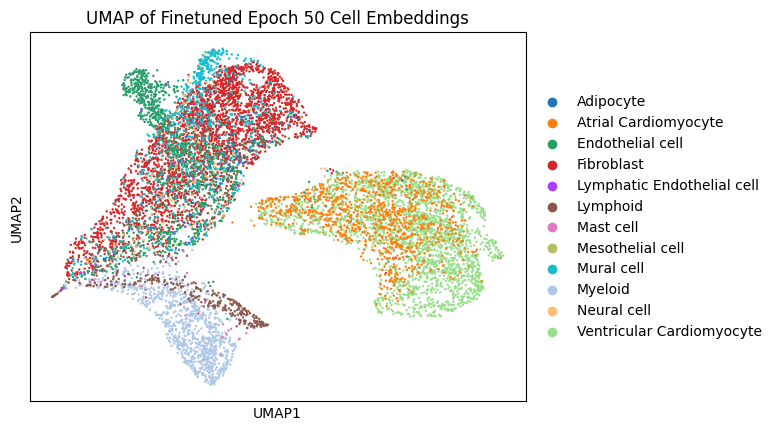

In [5]:
import scanpy as sc

# Compute the neighborhood graph using the fine-tuned embeddings
sc.pp.neighbors(adata, use_rep='cell_embeddings')

# Generate the UMAP embedding
sc.tl.umap(adata)

# Plot UMAP colored by cell type
# sc.pl.umap(adata, color='cell_type', title='UMAP of Pretrained Cell Embeddings',
#            save='_cell_embeddings_pretrained.png')
sc.pl.umap(adata, color='cell_type', title='UMAP of Finetuned Epoch 50 Cell Embeddings',
           save='_cell_embeddings_finetuned_epoch_50.png')

- output_path 변경

In [6]:
# Save the processed AnnData
# output_path = './output/finetune_DI/cell_embeddings_pretrained.h5ad'
output_path = './output/finetune_DI/cell_embeddings_finetuned_epoch_50.h5ad'
adata.write(output_path)
print(f"Processed AnnData saved at {output_path}")

Processed AnnData saved at ./output/finetune_DI/cell_embeddings_finetuned_epoch_50.h5ad
